<a href="https://colab.research.google.com/github/nurrizkyimani/mesh_on_demand/blob/master/Data_Mining_Nurrizky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Kaggle Thingy

In [ ]:
# {"username":"bocahrokok","key":"3470fa29c5901d007de08e0f97175435"}

import os 
os.environ['KAGGLE_USERNAME'] = "bocahrokok" 
os.environ['KAGGLE_KEY'] = "e84247255109e51ea31886308e848c7f"


# kaggle datasets download -d takuok/glove840b300dtxt

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/datamining/"


In [ ]:
%cd /content/drive/MyDrive/datamining/

/content/drive/MyDrive/datamining


In [ ]:
!kaggle datasets download -d takuok/glove840b300dtxt --unzip

 99% 2.07G/2.08G [00:30<00:00, 121MB/s]
100% 2.08G/2.08G [00:30<00:00, 73.5MB/s]


# Import 

In [5]:
# !pip install spacy==2.3.0
# import spacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_ner_bionlp13cg_md-0.2.5.tar.gz
# import en_ner_bionlp13cg_md
!pip install spacy==2.3.5
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz
import re, nltk, spacy, gensim
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from bs4 import BeautifulSoup
from nltk.tokenize import ToktokTokenizer
from nltk.stem import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from string import punctuation
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from keras.metrics import top_k_categorical_accuracy
from keras.optimizer_v2.adam import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, MaxPooling1D, Flatten
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import string
import itertools
import io
import json

     |████████████████████████████████| 12.0 MB 22.1 MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data loading

In [6]:
path = "/content/drive/MyDrive/datamining/"
indonesia_txt = path + "pubmed-indonesia-set.txt"
headache_txt = path + "pubmed-headache-set.txt"
longevity_txt = path + "pubmed-longevity-set.txt"
txt_labels = ["indonesia", "headache", 'longevity']
txt_paths = [indonesia_txt, headache_txt, longevity_txt]



In [7]:
#load file glove untuk embedding
glove_file = "/content/drive/MyDrive/datamining/glove.840B.300d.txt"
emb_dict = {}
glove = open(glove_file, encoding="utf-8")
for line in glove:
  values = line.split()
  word = values[0]
  try :
    vector = np.asarray(values[1:], dtype="float32")
  except :
    continue
  emb_dict[word] = vector
glove.close()

In [8]:
def get_abstract_and_mh(lines):
  s = "".join(lines)
  s = re.sub("\n\s+", "", s)
  s = s.strip()
  s = s.split("\n")

  abstract = ""
  mh = []
  for line in s:
    if line[0:5]=="AB  -":
      abstract = line[6:]
    elif line[0:5]=="MH  -":
      mh.append(line[6:])
  return [abstract, mh]

In [9]:
records = []
for i, p in enumerate(txt_paths):
  f = open(p, "r")
  temp_record = []
  r = []
  for line in f:
    if line != "\n":
      r.append(line)
    else :
      temp_record.append(get_abstract_and_mh(r))
      r = []
  f.close()
  records.append(temp_record)

In [10]:
records[0][1]

['Recent advances in the diagnosis and management of pulmonary arterial hypertension (PAH) have led to a significant improvement in the outcomes for patients with PAH. However, prompt and accurate diagnosis of PAH remains an unmet challenge due to lack of awareness and lack of meticulous data to profile the etiology and pathophysiology of this rare progressive disease, especially in low- and middle-income country. In Indonesia, the true prevalence and incidence of different subtypes of PAH in general population is still unknown. The Congenital HeARt Disease in adult and Pulmonary Hypertension (COHARD-PH) registry was the first single-center prospective registry in Indonesia, which indicated that almost 80% of adult patients with congenital heart disease (CHD) had experienced PAH and even Eisenmenger syndrome due to delayed diagnosis. Screening for early detection of asymptomatic CHD in children is yet to be systematically established in Indonesia, leading to undiagnosed and uncorrected

# Preprocessing: Lemmatization, Cleaning, stopWordsRemove; CombineRecord

In [11]:
token = ToktokTokenizer()
stop_words = set(stopwords.words("english"))
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
punct = punctuation

def clean_text(text):
    ''' Lowering text and removing undesirable marks
    '''
    
    text = re.sub("\d+", "", text)
    text = text.lower()
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text) # matches all whitespace characters
    text = text.strip(' ')
    return text
  
def strip_list_noempty(mylist):
    
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']
    
    
def clean_punct(text): 
    ''' Remove punctuations'''
    words = token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    
    for w in words:
        w = re.sub('^[0-9]*', " ", w)
        punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))
  
def stopWordsRemove(text):
    ''' Removing all the english stop words from a corpus
    Parameter:
    text: corpus to remove stop words from it
    '''
    words = token.tokenize(text)
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))
  
def lemmatization(texts, allowed_postags, stop_words=stop_words):
    ''' It keeps the lemma of the words (lemma is the uninflected form of a word),
    and deletes the underired POS tags
    
    Parameters:
    
    texts (list): text to lemmatize
    allowed_postags (list): list of allowed postags, like NOUN, ADL, VERB, ADV
    '''
    lemma = wordnet.WordNetLemmatizer()       
    doc = nlp(texts) 
    texts_out = []
    
    for token in doc:
        if token.pos_ in allowed_postags:
            
          if token.lemma_ not in ['-PRON-']:
              texts_out.append(token.lemma_)
              
          else:
              texts_out.append('')
     
    texts_out = ' '.join(texts_out)

    return texts_out

In [12]:
for r in records:
  for d in r:
    d[0] = clean_text(d[0])
    d[0] = BeautifulSoup(d[0]).get_text()
    d[0] = clean_punct(d[0])
    d[0] = stopWordsRemove(d[0])
    # d[0] = lemmatization(d[0], ["NOUN", "ADV", "ADL", "VERB"])

In [13]:
records[1][0]

['many types headache moreover many people different types headache time adequate treatment possible basis correct diagnosis technically terms content current diagnostics process headache based international classification headache disorders ichd beta produced auspices international headache society classification based distinction primary secondary headaches common primary headache types tension type headache migraine cluster headache application uniform diagnostic concepts essential come appropriate treatment various types headache',
 ['Headache/*classification/*diagnosis', 'Humans']]

In [14]:
# our holygrail of the processed dataset; 
records_combined = list(itertools.chain.from_iterable(records))

# Visualisation

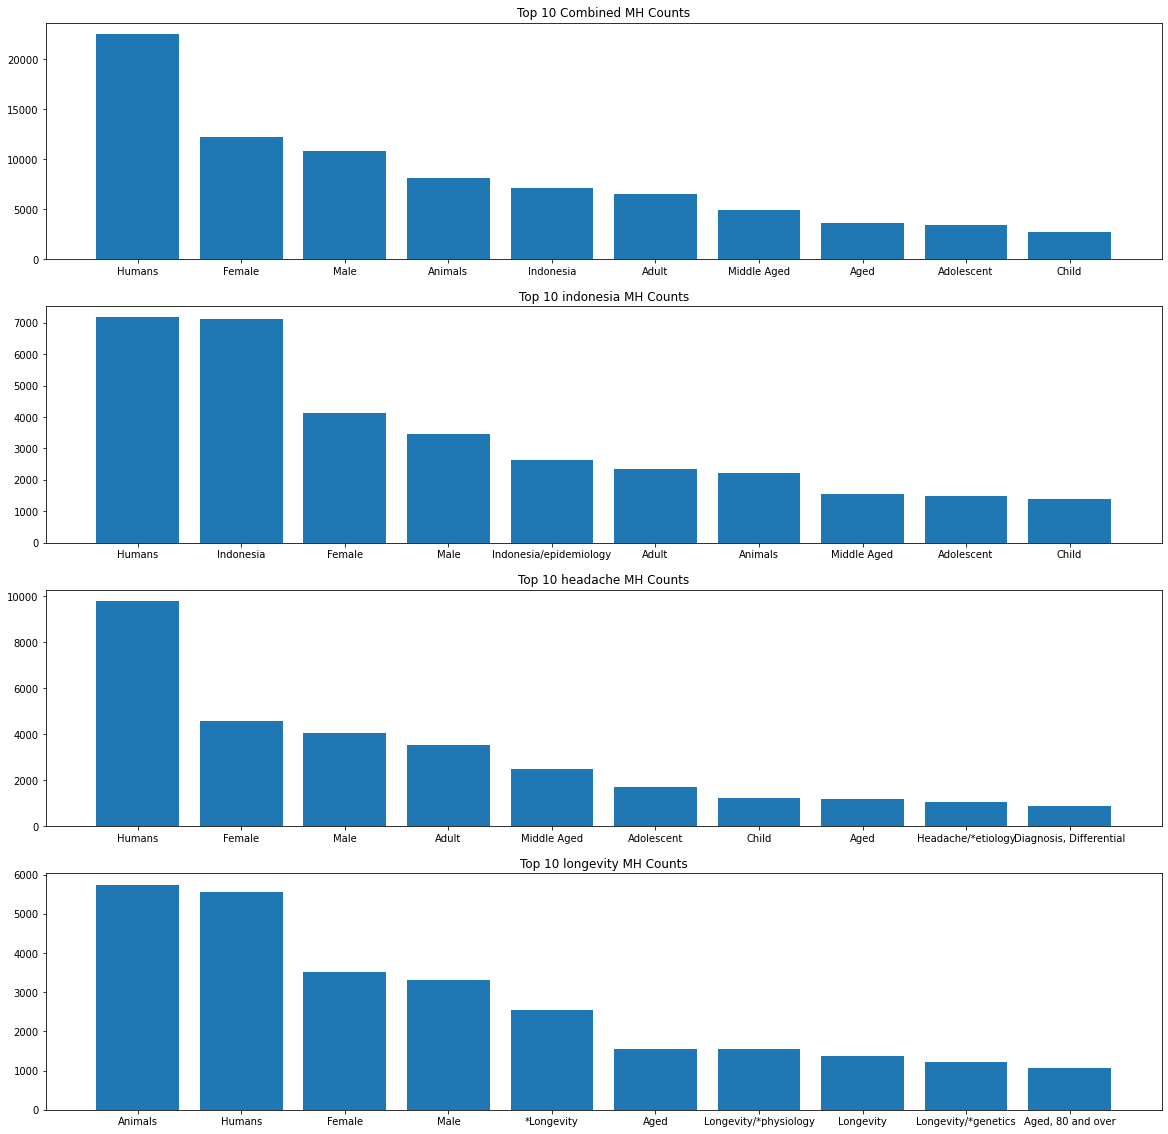

In [ ]:
mh_list = []
for d in records_combined:
  mh_list += d[1]
values, counts = np.unique(mh_list, return_counts=True)

fig, axs = plt.subplots(4, figsize=(20, 20))
ind = (-counts).argsort()[:10]
axs[0].set_title("Top 10 Combined MH Counts")
axs[0].bar(values[ind], counts[ind])

for i in range(len(records)):
  mh_list = []
  for d in records[i]:
    mh_list += d[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:10]
  axs[i+1].set_title("Top 10 {} MH Counts".format(txt_labels[i]))
  axs[i+1].bar(values[ind], counts[ind])

In [ ]:
def show_wordcloud(records, tag, bg_color):
  combined_text = ""
  for r in records:
    if tag in r[1]:
      combined_text += r[0]

  wordcloud = WordCloud(width = 800, height = 800,
                background_color = bg_color,
                min_font_size = 10).generate(combined_text)
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()

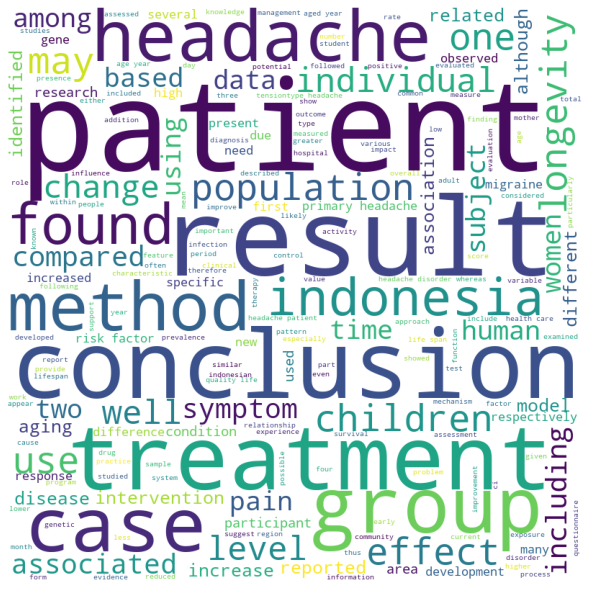

In [ ]:
show_wordcloud(records_combined, "Humans", "white")

In [ ]:
records_combined[0][1]

['*Betacoronavirus',
 'COVID-19',
 'Coronavirus Infections/*epidemiology',
 'Humans',
 'Indonesia/epidemiology',
 'Pandemics',
 'Pneumonia, Viral/*epidemiology',
 'SARS-CoV-2']

# Logistic Regression-Combined

In [ ]:
def one_v_all_learning(records):
  X = []
  y = []
  for d in records:
    X.append(d[0])
    y.append(d[1])
  X = np.array(X)
  y = np.array(y)
  # Sampling dataset
  vectorizer_X = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                    strip_accents = None, encoding = 'utf-8', 
                                    preprocessor=None, 
                                    token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                    max_features=1000)
  # 80/20 split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2,train_size=0.8, random_state=0)

  # TF-IDF matrices
  X_tfidf_train = vectorizer_X.fit_transform(X_train)
  X_tfidf_test = vectorizer_X.transform(X_test)

  #dimensionality reduction dengan PCA
  pca = PCA(n_components=0.95)
  X_tfidf_train = pca.fit_transform(X_tfidf_train.todense())
  X_tfidf_test = pca.transform(X_tfidf_test.todense())

  mh_list = []
  for d in records:
    mh_list += d[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:10]
  top_tags = values[ind]
  print(top_tags)
  reports = {}
  for i in range(len(top_tags)):
    y_train_temp = [1 if top_tags[i] in row else 0 for row in y_train]
    y_test_temp = [1 if top_tags[i] in row else 0 for row in y_test]
    clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1)
    clf.fit(X_tfidf_train, y_train_temp)
    preds = clf.predict(X_tfidf_test)
    print("Hasil Klasifikasi Kelas {}".format(top_tags[i]))
    print(classification_report(y_test_temp, preds))
    reports[top_tags[i]] = classification_report(y_test_temp, preds, output_dict=True)
  return reports

In [ ]:
logreg_report_combined = one_v_all_learning(records_combined)
# report_combined = one_v_all_learning(records_combined)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


['Humans' 'Female' 'Male' 'Animals' 'Indonesia' 'Adult' 'Middle Aged'
 'Aged' 'Adolescent' 'Child']
Hasil Klasifikasi Kelas Humans
              precision    recall  f1-score   support

           0       0.85      0.63      0.73      1484
           1       0.89      0.96      0.93      4516

    accuracy                           0.88      6000
   macro avg       0.87      0.80      0.83      6000
weighted avg       0.88      0.88      0.88      6000

Hasil Klasifikasi Kelas Female
              precision    recall  f1-score   support

           0       0.76      0.88      0.82      3564
           1       0.78      0.60      0.68      2436

    accuracy                           0.77      6000
   macro avg       0.77      0.74      0.75      6000
weighted avg       0.77      0.77      0.76      6000

Hasil Klasifikasi Kelas Male
              precision    recall  f1-score   support

           0       0.78      0.90      0.83      3846
           1       0.75      0.54      0.63   

# Logistic Regression-Result Visualization

In [ ]:
def get_average_accuracy(reports):
  accuracy = [r["accuracy"] for r in list(reports.values())]
  return sum(accuracy)/len(accuracy)

def get_average_precision(reports):
  precision = [r["1"]["precision"] for r in list(reports.values())]
  return sum(precision)/len(precision)

def get_average_recall(reports):
  recall = [r["1"]["recall"] for r in list(reports.values())]
  return sum(recall)/len(recall)

def get_average_f1(reports):
  f1 = [r["1"]["f1-score"] for r in list(reports.values())]
  return sum(f1)/len(f1)

<BarContainer object of 1 artists>

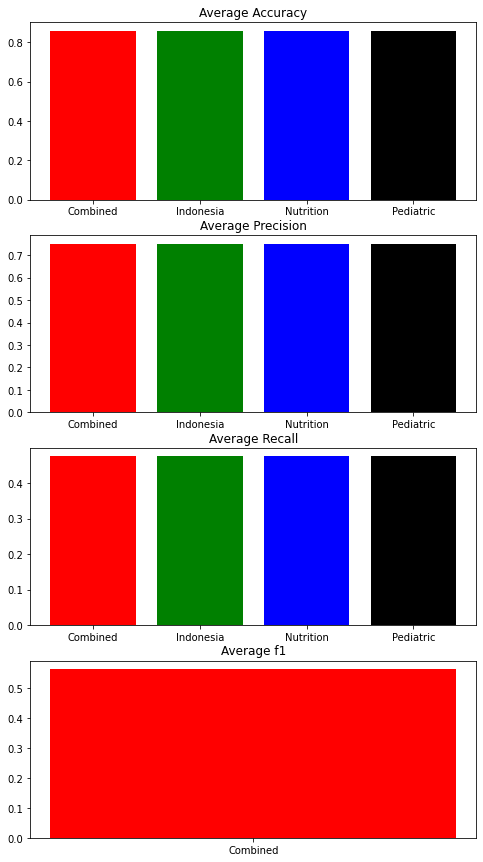

In [ ]:
fig, axs = plt.subplots(4, figsize=(8, 15))
color = ["red", "green", "blue", "black"]

report_combined = logreg_report_combined

axs[0].set_title("Average Accuracy")
acc_vals = [
            get_average_accuracy(report_combined),
            # get_average_accuracy(report_indo),
            # get_average_accuracy(report_nutrition),
            # get_average_accuracy(report_pediatric)
]
axs[0].bar(
    ["Combined", "Indonesia", "Nutrition", "Pediatric"],
    acc_vals,
    color = color
)

axs[1].set_title("Average Precision")
precision_vals = [
            get_average_precision(report_combined),
            # get_average_precision(report_indo),
            # get_average_precision(report_nutrition),
            # get_average_precision(report_pediatric)
]
axs[1].bar(
    ["Combined", "Indonesia", "Nutrition", "Pediatric"],
    precision_vals,
    color = color
)

axs[2].set_title("Average Recall")
recall_vals = [
            get_average_recall(report_combined),
            # get_average_recall(report_indo),
            # get_average_recall(report_nutrition),
            # get_average_recall(report_pediatric)
]
axs[2].bar(
    ["Combined", "Indonesia", "Nutrition", "Pediatric"],
    recall_vals,
    color = color
)

axs[3].set_title("Average f1")
f1_vals = [
            get_average_f1(report_combined),
            # get_average_f1(report_indo),
            # get_average_f1(report_nutrition),
            # get_average_f1(report_pediatric)
]
axs[3].bar(
    ["Combined",
    #  "Indonesia", "Nutrition", "Pediatric"
     ],
    f1_vals,
    color = color
)

# LSTM - Combined

In [ ]:
def lstm_multilabel_training(records):
  n_top_tags = 100
  mh_list = []
  for d in records:
    mh_list += d[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:n_top_tags]
  used_mh = values[ind]

  X = []
  y = []
  for d in records:
    X.append(d[0])
    y.append([mh for mh in d[1] if mh in used_mh])
  X = np.array(X)
  y = np.array(y)

  # The maximum number of words to be used. (most frequent)
  MAX_NB_WORDS = 30000
  # Max number of words in each abstract.
  MAX_SEQUENCE_LENGTH = 250
  # This is fixed.
  EMBEDDING_DIM = 300

  filter = np.array([len(t)!=0 for t in y])
  X_lstm = np.array(X)[filter]
  tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
  tokenizer.fit_on_texts(X_lstm)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  X_lstm = tokenizer.texts_to_sequences(X_lstm)
  X_lstm = pad_sequences(X_lstm, maxlen=MAX_SEQUENCE_LENGTH)
  print('Shape of data tensor:', X_lstm.shape)
  
  emb_matrix = np.zeros((MAX_NB_WORDS, EMBEDDING_DIM))
  for w, i in tokenizer.word_index.items():
      if i < MAX_NB_WORDS:
          vect = emb_dict.get(w)
          if vect is not None:
            emb_matrix[i] = vect
      else:
          break
  tags = pd.get_dummies(pd.Series(y).apply(pd.Series).stack()).sum(level=0)
  y_lstm = tags.values
  print('Shape of label tensor:', y_lstm.shape)
  X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(
        X_lstm,
        y_lstm, 
        test_size = 0.10, 
        random_state = 42)
  
  model = Sequential()
  model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_lstm.shape[1]))
  model.add(SpatialDropout1D(0.2))
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(n_top_tags, activation='sigmoid'))
  o = Adam(lr=0.001)
  model.compile(loss='binary_crossentropy', optimizer=o, metrics=[top_k_categorical_accuracy])
  model.layers[0].set_weights([emb_matrix])
  model.layers[0].trainable = False

  epochs = 5
  batch_size = 64

  history = model.fit(X_lstm_train, y_lstm_train, epochs=epochs,
                      batch_size=batch_size,
                      validation_split=0.1,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])
  
  accr = model.evaluate(X_lstm_test,y_lstm_test)
  print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
  return model, accr[1]

In [ ]:
model, lstm_acc_combined = lstm_multilabel_training(records_combined)
print(lstm_acc_combined)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


Found 76969 unique tokens.
Shape of data tensor: (29934, 250)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


Shape of label tensor: (29934, 100)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
379/379 [==============================] - 579s 2s/step - loss: 0.1514 - top_k_categorical_accuracy: 0.4331 - val_loss: 0.1185 - val_top_k_categorical_accuracy: 0.4915
Epoch 2/5
379/379 [==============================] - 554s 1s/step - loss: 0.1132 - top_k_categorical_accuracy: 0.4889 - val_loss: 0.1102 - val_top_k_categorical_accuracy: 0.4852
Epoch 3/5
129/379 [=========>....................] - ETA: 6:05 - loss: 0.1082 - top_k_categorical_accuracy: 0.4972

# Clustering Method

In [15]:
records_combined[0]

['coronavirus disease covid pandemic ongoing problem countries world indonesia greatly affected covid case fatality rate cfr end march room improvement related unreadingess healthcare facility major steps taken government suggested country stricter stayathome notice suppress spread imposing lockdown large scale improve healthcare service increase availability personal protective equipments ppe important avoid epidemic peak potentially overwhelms healthcare service quarantining case contacts lockdown may prolong epidemic doubling time significantly demand health system likely grow since number covid case likely rise effective procedures protecting medical staff infection essential scientific research indonesia also crucial provide suggestion recommendation pertinent covid',
 ['*Betacoronavirus',
  'COVID-19',
  'Coronavirus Infections/*epidemiology',
  'Humans',
  'Indonesia/epidemiology',
  'Pandemics',
  'Pneumonia, Viral/*epidemiology',
  'SARS-CoV-2']]

In [18]:
def transform_kmeans(records):
  X = []
  y = []
  for d in records:
    X.append(d[0])
    y.append(d[1])
  X = np.array(X)
  y = np.array(y)

  # Sampling dataset
  vectorizer_X = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                    strip_accents = None, encoding = 'utf-8', 
                                    preprocessor=None, 
                                    token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                    max_features=1000)
  # 80/20 split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2,train_size=0.8, random_state=0)

  # TF-IDF matrices
  X_tfidf_train = vectorizer_X.fit_transform(X_train)
  X_tfidf_test = vectorizer_X.transform(X_test)

  #dimensionality reduction dengan PCA
  pca = PCA(n_components=0.95)
  X_tfidf_train = pca.fit_transform(X_tfidf_train.todense())
  X_tfidf_test = pca.transform(X_tfidf_test.todense())

  mh_list = []
  for d in records:
    mh_list += d[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:10]
  top_tags = values[ind]
  print(top_tags)

  print(type(X_tfidf_train))
  print(type(X_tfidf_test))

  return X_tfidf_train, X_tfidf_test, top_tags








In [19]:
X_tfidf_train, X_tfidf_test, top_tags = transform_kmeans(records_combined)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


['Humans' 'Female' 'Male' 'Animals' 'Indonesia' 'Adult' 'Middle Aged'
 'Aged' 'Adolescent' 'Child']
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def clustering_kmeans(records):
  X = []
  y = []

  for d in records:
    X.append(d[0])
    y.append(d[1])

  X = np.array(X)
  y = np.array(y)

  # Sampling dataset
  vectorizer_X = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                    strip_accents = None, encoding = 'utf-8', 
                                    preprocessor=None, 
                                    token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                    max_features=1000)
  # 80/20 split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2,train_size=0.8, random_state=0)

  # TF-IDF matrices
  X_tfidf_train = vectorizer_X.fit_transform(X_train)
  X_tfidf_test = vectorizer_X.transform(X_test)

  #dimensionality reduction dengan PCA
  pca = PCA(n_components=0.95)
  X_tfidf_train = pca.fit_transform(X_tfidf_train.todense())
  X_tfidf_test = pca.transform(X_tfidf_test.todense())

  mh_list = []
  for d in records:
    mh_list += d[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:10]
  top_tags = values[ind]
  print(top_tags)

  print(type(X_tfidf_train))
  print(type(X_tfidf_test))


  true_k = len(top_tags)
  model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=1)
  model.fit(X_tfidf_train)

  print("Top terms per cluster:")
  order_centroids = model.cluster_centers_.argsort()[:, ::-1]
  terms = vectorizer_X.get_feature_names()
  for i in range(true_k):
      print("Cluster %d:" % i),
      for ind in order_centroids[i, :10]:
          print(' %s' % terms[ind]),
      print

  print("\n")
  print("Prediction")

  return model 

In [27]:
cluster_model = clustering_kmeans(records_combined)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


['Humans' 'Female' 'Male' 'Animals' 'Indonesia' 'Adult' 'Middle Aged'
 'Aged' 'Adolescent' 'Child']
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Top terms per cluster:
Cluster 0:
 csf
 confirmed
 absence
 approximately
 al
 disorder
 comparison
 also
 developed
 efficacy
Cluster 1:
 activities
 active
 according
 addition
 aging
 along
 activity
 area
 among
 almost
Cluster 2:
 around
 animals
 approximately
 ability
 anxiety
 another
 application
 aging
 approaches
 associated
Cluster 3:
 absence
 according
 across
 adolescents
 addition
 also
 agerelated
 alternative
 aim
 ages
Cluster 4:
 access
 absence
 acute
 accumulation
 action
 animal
 adverse
 appropriate
 ages
 allele
Cluster 5:
 appears
 access
 allele
 applied
 aim
 common
 demonstrate
 anxiety
 design
 aims
Cluster 6:
 account
 accumulation
 active
 additional
 activities
 absence
 access
 adjusted
 aging
 age
Cluster 7:
 ability
 absence
 account
 active
 acute
 activities
 adolescents
 action
 adjusted
 aimed
Cluster

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
prediction = cluster_model.predict(X_tfidf_test)
print(prediction)

[7 9 9 ... 6 0 6]


In [23]:
rs = X_tfidf_test[1].reshape(1,-1)
prediction_test = cluster_model.predict(rs)
print(prediction_test)

[9]


# Draft Evaluation Matrix

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from sklearn.metrics import silhouette_samples, silhouette_score, rand_score

def clustering_kmeans_2(records):
  X = []
  y = []

  for d in records:
    X.append(d[0])
    y.append(d[1])

  X = np.array(X)
  y = np.array(y)

  # Sampling dataset
  vectorizer_X = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                    strip_accents = None, encoding = 'utf-8', 
                                    preprocessor=None, 
                                    token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                    max_features=1000)
  # 80/20 split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2,train_size=0.8, random_state=0)

  # TF-IDF matrices
  X_tfidf_train = vectorizer_X.fit_transform(X_train)
  X_tfidf_test = vectorizer_X.transform(X_test)

  #dimensionality reduction dengan PCA
  pca = PCA(n_components=0.95)
  X_tfidf_train = pca.fit_transform(X_tfidf_train.todense())
  X_tfidf_test = pca.transform(X_tfidf_test.todense())

  mh_list = []
  for d in records:
    mh_list += d[1]
  values, counts = np.unique(mh_list, return_counts=True)
  ind = (-counts).argsort()[:20]
  top_tags = values[ind]
  print("top tags for cluster:  ", top_tags)


  true_k = len(top_tags)
  model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=1)
  cluster_labels = model.fit_predict(X_tfidf_train)


  # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
  silhouette_avg = silhouette_score(X_tfidf_train, cluster_labels)
  print(
      "For n_clusters =",
      true_k,
      "The average silhouette_score is :",
      silhouette_avg,
  )

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(X_tfidf_train, cluster_labels)

  # rand_avg = rand_score(X_tfidf_train, cluster_labels)

  print("Top terms per cluster:")
  order_centroids = model.cluster_centers_.argsort()[:, ::-1]
  terms = vectorizer_X.get_feature_names()
  for i in range(true_k):
      print("Cluster %d:" % i),
      print("Cluster : ", top_tags[i]),
      for ind in order_centroids[i, :10]:
          print(' %s' % terms[ind]),
      print

  print("\n")
  print("Prediction")

  return model 



In [27]:
cluster_model = clustering_kmeans_2(records_combined)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


top tags for cluster:   ['Humans' 'Female' 'Male' 'Animals' 'Indonesia' 'Adult' 'Middle Aged'
 'Aged' 'Adolescent' 'Child' 'Indonesia/epidemiology' '*Longevity'
 'Aged, 80 and over' 'Longevity/*physiology' 'Child, Preschool'
 'Young Adult' 'Longevity' 'Cross-Sectional Studies' 'Longevity/*genetics'
 'Prevalence']
For n_clusters = 20 The average silhouette_score is : 0.17629936899505314
Top terms per cluster:
Cluster 0:
Cluster :  Humans
 activities
 active
 according
 addition
 aging
 along
 aged
 almost
 activity
 area
Cluster 1:
Cluster :  Female
 absence
 action
 additional
 according
 accumulation
 adults
 activities
 age
 ageing
 allele
Cluster 2:
Cluster :  Male
 access
 absence
 additional
 active
 accumulation
 adolescents
 across
 ageing
 action
 activities
Cluster 3:
Cluster :  Animals
 account
 active
 accumulation
 additional
 activities
 adjusted
 access
 age
 absence
 acid
Cluster 4:
Cluster :  Indonesia
 absence
 across
 account
 according
 ageing
 agerelated
 ages
 adol

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
